In [1]:

from fastembed import SparseTextEmbedding
from qdrant_client import QdrantClient, models
import os
import json
from langchain_openai import AzureOpenAIEmbeddings
from qdrant_client import QdrantClient
client = QdrantClient("http://localhost:6333", timeout=300)

import math
import random

DATASET = "quora"
MODEL = "hybrid_bm25"

RESULTS_FILE = f"./results/{DATASET}/{MODEL}.jsonl"
limit = 10
NUM_BOOTSTRAP_SAMPLES = 1000

In [ ]:
# this is for normalised discounted cumulative gain, adjust k at the top
def ndcg_at_k(retrieved, relevant, k=limit):                                # binary-based cumumaltive gain implementation (doc either relevant or not) 
    dcg = 0.0
    for i, doc_id in enumerate(retrieved[:k]):
        if doc_id in relevant:
            dcg += 1 / math.log2(i + 2)
    ideal_hits = min(len(relevant), k)
    idcg = sum(1 / math.log2(i + 2) for i in range(ideal_hits))
    return dcg / idcg if idcg > 0 else 0


#this is for mean average precision, not used in the final results overview
def average_precision(retrieved, relevant):
    sum_precisions = 0.0
    num_hits = 0
    for i, doc_id in enumerate(retrieved, start=1):
        if doc_id in relevant:
            num_hits += 1
            sum_precisions += num_hits / i
    if len(relevant) == 0:
        return 0
    return sum_precisions / len(relevant)

#this is for mean reciprocal rank, not used in the final results overview
def reciprocal_rank(retrieved, relevant):
    for i, doc_id in enumerate(retrieved, start=1):
        if doc_id in relevant:
            return 1.0 / i
    return 0

# Function for bootstrapping standard deviation
def bootstrap_mean_and_ci(metric_list, num_samples=10000, ci=95):
    means = []
    for _ in range(num_samples):                                    # this iterates over the number of dataset version you want to bootstrap with
        sample = random.choices(metric_list, k=len(metric_list))    # uses random to resample with substitation using the individual metrics from your metric list
        means.append(sum(sample) / len(sample))                     # gets you the average score for each resampled dataset
    means.sort()                                                    # sorts you results from largest to smallest                       
    lower_idx = int((100 - ci) / 2 / 100 * num_samples)             # identifies the index of the lower confidence interval
    upper_idx = int((100 - (100 - ci) / 2) / 100 * num_samples)     # identifies the index of the upper confidence interval
    lower_bound = means[lower_idx]                                  # retrieves the value that defines the lower bound
    upper_bound = means[upper_idx]                                  # retrieves the value that defines the upper bound

    mean_of_means = sum(means) / len(means)
    return mean_of_means, (lower_bound, upper_bound)

In [ ]:
def load_queries():
    queries = {}
    with open(f"./datasets/{DATASET}/queries.jsonl", "r") as file:
        for line in file:
            row = json.loads(line)
            queries[str(row["_id"])] = {**row, "doc_ids": []}

    with open(f"./datasets/{DATASET}/test.tsv", "r") as file:
        next(file)
        for line in file:
            query_id, doc_id, score = line.strip().split("\t")
            if int(score) > 0:
                queries[query_id]["doc_ids"].append(doc_id)

    return {qid: q for qid, q in queries.items() if len(q["doc_ids"]) > 0}


# Load ground truths
queries = load_queries()


In [14]:
# Containers for evaluation metrics
n = 0
hits = 0
num_queries = 0
num_queries_with_hits = 0
precisions = []
recalls = []
f1s = []
ndcgs = []
map_scores = []
rr_scores = []

# Evaluation loop; the script for evaluation was used and modified based on qdrant's evaluation logic to match replicated tasks
with open(RESULTS_FILE, "r") as f:
    for line in f:
        entry = json.loads(line)
        query_id = str(entry["query_id"])

        if query_id not in queries:
            continue

        found_ids = [str(doc["doc_id"]) for doc in entry["results"][:limit]]
        relevant = set(queries[query_id]["doc_ids"])

        query_hits = len(set(found_ids) & relevant)
        if query_hits > 0:
            num_queries_with_hits += 1

        precision = query_hits / limit
        recall = query_hits / len(relevant)
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        ndcg = ndcg_at_k(found_ids, relevant, k=limit)
        ap = average_precision(found_ids, relevant)
        rr = reciprocal_rank(found_ids, relevant)

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        ndcgs.append(ndcg)
        map_scores.append(ap)
        rr_scores.append(rr)

        hits += query_hits
        n += len(relevant)
        num_queries += 1

# Final evaluation scores and their confidence intervals
print(f"\nTotal hits: {hits} out of {n} (Recall base), which is {hits / n:.4f}")
print(f"Hit Ratio@{limit}: {num_queries_with_hits} out of {num_queries} → {num_queries_with_hits / num_queries:.4f}")

mean_precision, (precision_ci_lower, precision_ci_upper) = bootstrap_mean_and_ci(precisions)
mean_recall, (recall_ci_lower, recall_ci_upper) = bootstrap_mean_and_ci(recalls)
mean_ndcg, (ndcg_ci_lower, ndcg_ci_upper) = bootstrap_mean_and_ci(ndcgs)
mean_map, (map_ci_lower, map_ci_upper) = bootstrap_mean_and_ci(map_scores)
mean_mrr, (mrr_ci_lower, mrr_ci_upper) = bootstrap_mean_and_ci(rr_scores)

# overall results
print(f"Precision@{limit}: {mean_precision:.4f} (95% CI: {precision_ci_lower:.4f} - {precision_ci_upper:.4f})")
print(f"Recall@{limit}: {mean_recall:.4f} (95% CI: {recall_ci_lower:.4f} - {recall_ci_upper:.4f})")
print(f"NDCG@{limit}: {mean_ndcg:.4f} (95% CI: {ndcg_ci_lower:.4f} - {ndcg_ci_upper:.4f})")
print(f"MAP@{limit}: {mean_map:.4f} (95% CI: {map_ci_lower:.4f} - {map_ci_upper:.4f})")
print(f"MRR@{limit}: {mean_mrr:.4f} (95% CI: {mrr_ci_lower:.4f} - {mrr_ci_upper:.4f})")

# just the intervals for latex formatting
print(f" The intervals: & ({precision_ci_lower:.4f}, {precision_ci_upper:.4f}) &",
        f"({recall_ci_lower:.4f}, {recall_ci_upper:.4f}) &",
        f"({ndcg_ci_lower:.4f}, {ndcg_ci_upper:.4f}) &",
        f"({map_ci_lower:.4f}, {map_ci_upper:.4f}) &",
        f"({mrr_ci_lower:.4f}, {mrr_ci_upper:.4f}) \\"
        )


Hit Ratio@10: 9286 out of 10000 → 0.9286
Precision@10: 0.1194 (95% CI: 0.1179 - 0.1210)
Recall@10: 0.8854 (95% CI: 0.8798 - 0.8910)
NDCG@10: 0.7891 (95% CI: 0.7829 - 0.7953)
MAP@10: 0.7410 (95% CI: 0.7337 - 0.7481)
MRR@10: 0.7817 (95% CI: 0.7748 - 0.7884)
& 0.1194 & 0.7891 & 0.7411 & 0.7816 & 0.9286
 The intervals: & (0.1179, 0.1210) & (0.8798, 0.8910) & (0.7829, 0.7953) & (0.7337, 0.7481) & (0.7748, 0.7884) \


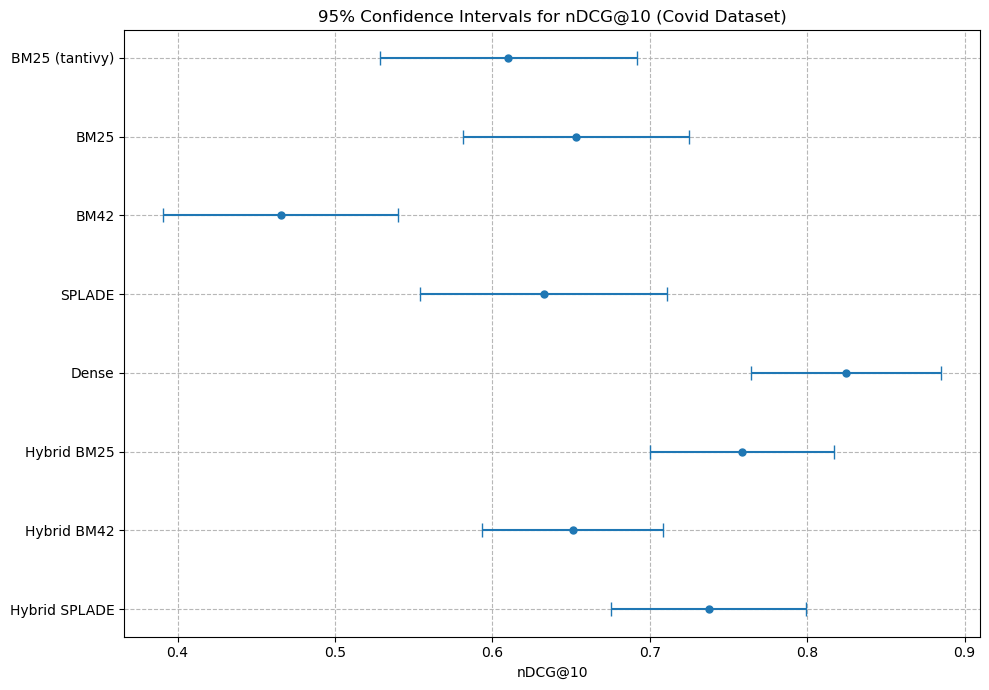

In [12]:
import matplotlib.pyplot as plt

DATASET = "quora"
DATASET_NAME = "Quora"
METRICS = "nDCG"

# Create the data for plotting
models = [
    "BM25 (tantivy)",
    "BM25",
    "BM42",
    "SPLADE",
    "Dense",
    "Hybrid BM25",
    "Hybrid BM42",
    "Hybrid SPLADE"
]

precision_cis = [(0.5287, 0.6917),
(0.5813, 0.7249),
(0.3910, 0.5402),
(0.5542, 0.7109),
(0.7644, 0.8851),
(0.6999, 0.8172),
(0.5933, 0.7086),
(0.6755, 0.7992) ]

midpoints = [(low + high) / 2 for low, high in precision_cis]
error_bars = [(high - low) / 2 for low, high in precision_cis]

# Create the plot
plt.figure(figsize=(10, 7))
plt.errorbar(midpoints, range(len(models)), xerr=error_bars, fmt='o', capsize=5, markersize=5)
plt.yticks(range(len(models)), models)
plt.gca().invert_yaxis()
plt.xlabel(f'{METRICS}@10')
plt.title(f'95% Confidence Intervals for {METRICS}@10 ({DATASET_NAME} Dataset)')
plt.grid(True, linestyle='--', alpha=0.9)

plt.tight_layout()
plt.savefig(f'/./results/{DATASET}/{METRICS}_int.png', dpi=300, bbox_inches='tight')
plt.show()